In [21]:
# library imports
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import trange, tqdm
import pickle
import folium
from matplotlib import cm


# importing our helper functions
# from helper import *

# Config
from config import * # we standardise config across all files


In [22]:
random.seed(SEED)

NUM_CUSTOMERS = 50
NUM_CHARGERS = 10
NUM_VEHICLES = 5

# Electric Vehicle Points
ev_pts = pd.read_csv("Unique_EV_Points.csv")
charge_pts = ev_pts.sample(n=NUM_CHARGERS, random_state=SEED)[['Longitude', 'Latitude']] # dataframe
charge_pts_list = list(charge_pts.itertuples(index=False, name=None)) # list

# Delivery locations Points
dl = pd.read_csv("DeliveryLocations.csv")
todays_locations = dl.sample(n=NUM_CUSTOMERS, random_state=SEED)
dl_list = list(todays_locations.itertuples(index=False, name=None))

# Fedex Ship Centre
fedex_centre = [(104.0023106, 1.3731437)]

locations = fedex_centre + dl_list + charge_pts_list # combined list of all locations
print(locations)

[(104.0023106, 1.3731437), (103.9031463, 1.392836795), (103.7200224, 1.350675728), (103.743248, 1.389594981), (103.7671055, 1.321415897), (103.8396421, 1.438097638), (103.854151, 1.321580687), (103.8937135, 1.382904957), (103.701603, 1.338132418), (103.8516161, 1.369122417), (103.9106985, 1.393069499), (103.7958279, 1.444411907), (103.7385184, 1.32378355), (103.764451, 1.376263241), (103.9009883, 1.378930838), (103.8293115, 1.2823137), (103.9071162, 1.393322372), (103.8428226, 1.356294894), (103.8204697, 1.277395442), (103.7325787, 1.347666576), (103.8669618, 1.353848111), (103.8437197, 1.378238594), (103.808264, 1.294642864), (103.9068635, 1.403012767), (103.8507093, 1.303460962), (103.7254507, 1.3508614), (103.9534387, 1.363800158), (103.8331176, 1.430100193), (103.869581, 1.355949453), (103.9124627, 1.401126351), (103.8907051, 1.387862243), (103.9368755, 1.345540335), (103.9099237, 1.329245367), (103.7772942, 1.443282043), (103.8762905, 1.393398979), (103.7460768, 1.351856129), (103

## Calculate the distance, time and energy between locations

In [23]:
# Total nodes: 1 depot + customers + chargers
n = len(locations)
customer_nodes = list(range(1, 1 + NUM_CUSTOMERS)) # gets the index/nodes of customers
charger_nodes = list(range(1 + NUM_CUSTOMERS, n))  

# Compute Distance & Energy Matrices
distance_matrix = np.zeros((n, n))
time_matrix = np.zeros((n, n))
energy_matrix = np.zeros((n, n))

def calc_dist(p1, p2):
    """
    Calculates the straight-line (euclidean) distance
    """
    lon_diff = p1[0] - p2[0]
    lat_diff = p1[1] - p2[1]
    return 111 * np.sqrt(lon_diff**2 + lat_diff**2)

for i in range(n):
    for j in range(n):
        if i != j:
            dist = calc_dist(locations[i], locations[j])
            distance_matrix[i][j] = dist
            energy_matrix[i][j] = dist * ENERGY_PER_KM
            time_matrix[i][j] = dist * TIME_PER_KM

def total_distance(routes, locations):
    """
    Returns total distance of for all route in routes
    """
    dist = 0.0
    for route in routes:
        for i in range(len(route) - 1):
            # dist += calc_dist(locations[route[i]], locations[route[i+1]])
            dist += distance_matrix[route[i]][route[i+1]]
    return dist

def num_activated_vehicles(routes):
    """
    Calculates number of activated vehicles
    """
    return len(routes) - sum(1 for route in routes if route == [0, 0])

In [24]:
random.seed(SEED)    

# Helper Functions
def is_route_feasible(route, locations): # to be optimised
    """
    Ensures a single route is feasible by inserting charging stations if needed.
    Returns:
        - A new route with chargers inserted if feasible.
        - False if no feasible charger insertion exists.
    """
    battery = BATTERY_CAPACITY
    new_route = [route[0]]
    total_time_taken = 0

    for i in range(1, len(route)):
        prev, curr = new_route[-1], route[i]
        to_discharge = energy_matrix[prev][curr]
        
        # if desired destination uses too much battery (with some safety buffer)
        if to_discharge > battery - random.uniform(1, 5):
            # Find nearest charger that is reachable from prev and can reach curr
            inserted = False
            charger = np.argmin(distance_matrix[prev][1+NUM_CUSTOMERS:], axis=0) + 1 + NUM_CUSTOMERS

            if curr < 1+NUM_CUSTOMERS: # next destination is not a charger
                d1 = energy_matrix[prev][charger]
                d2 = energy_matrix[charger][curr]

                if d1 <= battery and d2 <= BATTERY_CAPACITY:
                    new_route.append(charger)
                    new_route.append(curr)
                    total_time_taken += time_matrix[prev, charger] + time_matrix[charger, curr]
                    battery = BATTERY_CAPACITY-d2
                    inserted = True
                        
            else: # next destination is a charger
                # find a nearer charger
                d1 = energy_matrix[prev][charger]
                
                if d1 <= battery:
                    new_route.append(charger)
                    total_time_taken += time_matrix[prev, charger]
                    battery = BATTERY_CAPACITY
                    inserted = True
            
            if not inserted:
                return False, "battery"  # infeasible
        else:
            battery -= to_discharge
            new_route.append(curr)

            # add time taken to travel
            total_time_taken += time_matrix[prev, curr]
        
            if curr >= 1 + NUM_CUSTOMERS:
                battery = BATTERY_CAPACITY
    
    # exceeded total time to complete
    if total_time_taken > TOTAL_TIME_ALLOWED:
        return False, "time"

    # return new_route
    """
    Remove unnecessary chargers from route (to be optimised)
    """
    optimized_route = [new_route[0]]
    battery = BATTERY_CAPACITY
    for i in range(1, len(new_route)):
        prev = optimized_route[-1]
        curr = new_route[i]
        to_discharge = energy_matrix[prev][curr]

        # If curr is a charger, check if we can skip it
        if curr >= 1 + NUM_CUSTOMERS and i + 1 < len(new_route):
            next_node = new_route[i + 1]
            to_next = energy_matrix[prev][next_node]
            if to_next < battery - random.uniform(1, 1.5):
                # Skip this charger
                continue

        battery -= to_discharge
        if curr >= 1 + NUM_CUSTOMERS:
            battery = BATTERY_CAPACITY
        optimized_route.append(curr)

    return optimized_route, "ok"

        


def swap_routes(routes):
    """
    Swap client locations between two vehicles.
    """
    new_routes = [r[:] for r in routes]

    not_charger_or_depot = False

    # prevent swapping of chargers, only client locations
    while not_charger_or_depot == False:
        # choose 2 vehicles to swap routes
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

        # randomly choose two client locations of the vehicles to swap
        i = random.randint(0, len(new_routes[veh_1])-1)
        j = random.randint(0, len(new_routes[veh_2])-1)

        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS and 0 < new_routes[veh_2][j] < 1 + NUM_CUSTOMERS and new_routes[veh_1][i] != new_routes[veh_2][j]:
            not_charger_or_depot = True
    
    new_routes[veh_1][i], new_routes[veh_2][j] = new_routes[veh_2][j], new_routes[veh_1][i]
    return new_routes

def swap_within_vehicle(routes):
    """
    Swap routes within one vehicle
    """
    new_routes = [r[:] for r in routes]

    customer_indices = []

    # Retry until we find a vehicle with at least 1 customer
    while len(customer_indices) < 2:
        vehicle = random.randint(0, len(new_routes) - 1)
        
        customer_indices = [i for i in range(len(new_routes[vehicle]))
                            if 0 < new_routes[vehicle][i] < 1 + NUM_CUSTOMERS]

    route = new_routes[vehicle]
    i, j = random.sample(customer_indices, 2)
    route[i], route[j] = route[j], route[i]
    new_routes[vehicle] = route

    return new_routes

def k_opt_within(routes, k=2): # check again
    """
    Performs K-Opt within a single vehicle's route
    """
    assert k in (2,3) # function oni allows 2-opt or 3-opt

    new_routes = [r[:] for r in routes] 
    
    # exclude depot at start and end
    # vehicle route is long enough to k-opt on
    vehicle_choices = [i for i, route in enumerate(new_routes) if len(route)-2 >= k]

    veh = random.choice(vehicle_choices)
    route = new_routes[veh]

    # find customers indices to k-opt on
    customer_indices = [i for i in range(1, len(route) - 1)  
                        if 0 < route[i] < 1 + NUM_CUSTOMERS]

    if len(customer_indices) < k:
        return new_routes

    # List of points for cutting 
    selected = sorted(random.sample(customer_indices, k))

    if k == 2:
        i, j = selected # Choose 2 points to cut so that i < j
        route[i:j+1] = reversed(route[i:j+1])
    elif k == 3:
        i, j, l = selected # Choose 3 points to cut so that i < j < k

        option = random.choice([1, 2, 3])
        if option == 1:
            route[i:j+1] = reversed(route[i:j+1])
        elif option == 2:
            seg1, seg2 = route[i:j+1], route[j+1:l+1]
            route[i:l+1] = seg2 + seg1
        elif option == 3:
            route[i:l+1] = reversed(route[i:l+1])

    new_routes[veh] = route
    return new_routes
    
    # i, j = sorted(random.sample(customer_indices, 2))

    # route[i:j+1] = reversed(route[i:j+1])

    # new_routes[veh] = route
    # return new_routes

def k_opt_between_vehicles(routes, k=2):
    """
    Performs K-Opt between 2 vehicles
    """
    assert k==2 # function oni allows 2-opt

    new_routes = [r[:] for r in routes]
    
    eligible_vehicles = [i for i, r in enumerate(new_routes) if len(r) > 2]

    if len(eligible_vehicles) < 2:
        return new_routes

    veh1, veh2 = random.sample(eligible_vehicles, 2)
    route1, route2 = new_routes[veh1], new_routes[veh2]

    cust1 = [i for i in range(1, len(route1) - 1)]
    cust2 = [i for i in range(1, len(route2) - 1)]

    if not cust1 or not cust2:
        return new_routes

    i = random.choice(cust1)
    j = random.choice(cust2)

    if k == 2:
        # Swap short segments (up to 2 elements)
        len1 = min(2, len(route1) - 2)
        len2 = min(2, len(route2) - 2)
        seg1_start = max(1, i - len1 + 1)
        seg2_start = max(1, j - len2 + 1)
        seg1 = route1[seg1_start:i+1]
        seg2 = route2[seg2_start:j+1]
        route1[seg1_start:i+1] = seg2
        route2[seg2_start:j+1] = seg1

    new_routes[veh1] = route1
    new_routes[veh2] = route2
    return new_routes



In [25]:
random.seed(SEED)
def tweak_insert(routes):
    """
    Remove customer from one vehicle and insert to another vehicle
    """
    new_routes = [r[:] for r in routes] 
    veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

    # Get all valid customer indices in veh_1 (not depot or charger)
    customer_indices = [i for i in range(len(new_routes[veh_1]))
                        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # Retry until we find a vehicle with at least 1 customer
    while not customer_indices:
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)
        customer_indices = [i for i in range(len(new_routes[veh_1]))
                            if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # choose up to 3 customers
    num_to_move = min(1, len(customer_indices))
    from_indices = sorted(random.sample(customer_indices, num_to_move), reverse=True)

    customers = []
    for idx in from_indices:
        customers.append(new_routes[veh_1].pop(idx))

    # ensure veh_2 route has basic structure if no client locations left
    # aka vehicle becomes inactive
    if len(new_routes[veh_2]) < 2:
        new_routes[veh_2] = [0, 0] 

    # insert each customer at a random position in veh_2
    for customer in customers:
        insert_pos = random.randint(1, len(new_routes[veh_2]) - 1)
        new_routes[veh_2].insert(insert_pos, customer)

    return new_routes

new_routes = [[0, 5, 3, 8,15,14,17, 0], [0, 2, 1, 6,12 , 11, 13, 0]]
tweak_insert(new_routes)

[[0, 5, 3, 8, 15, 14, 17, 13, 0], [0, 2, 1, 6, 12, 11, 0]]

## Generate a Basic Feasible Solution and View it

Is route feasible? (False, 'time')
Is route feasible? (False, 'time')
Is route feasible? (False, 'time')
Is route feasible? (False, 'time')
Is route feasible? (False, 'time')


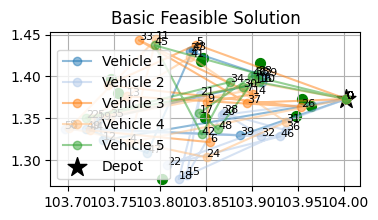

In [26]:
random.seed(5)

def generate_initial_solution():# -> list:
    """
    naive method - create BFS by randomly assigning customers to vehicles
    """
    nodes = list(range(1, 1 + NUM_CUSTOMERS))  # customer indices
    random.shuffle(nodes)
    split = np.array_split(nodes, NUM_VEHICLES)

    routes = []
    for chunk in split:
        # starting and ending is at the depot
        r = [0] + list(chunk) + [0]
        # randomly insert a charger if route is long
        if not is_route_feasible(r, locations):
            r.insert(len(r)//2, random.randint(1 + NUM_CUSTOMERS, len(locations) - 1))
        routes.append(r)
    
    return routes

colors = [plt.get_cmap("tab20")(i) for i in range(NUM_VEHICLES)]
current_solution = generate_initial_solution()


locations_e = np.array([[lat, lon] for (lat, lon) in locations])

plt.figure(figsize=(4, 2))
for i, route in enumerate(current_solution):
    print(f"Is route feasible? {is_route_feasible(route, locations)}")
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, marker='o', label=f"Vehicle {i+1}")

    for idx in route:
        plt.text(locations_e[idx, 0], locations_e[idx, 1], str(idx), fontsize=8)

plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')

plt.title("Basic Feasible Solution")
plt.legend()
plt.grid(True)
plt.show()

## Simulated Annealing Algorithm

In [27]:
random.seed(SEED)

import time

best_cost = better_cost = total_distance(current_solution, locations)
best_solution = better_solution = current_solution

INIT_TEMP = 10000 

COOL_RATE = 0.8 # setting to 0.9 cooling rate yields a result of 172.72, 0.8 gives 152.66
curr_temp = INIT_TEMP

MAX_ITER = 100000 # change max iter
CPU_TIME = 300 # set maximum cpu time

message = "ok"

cpu_times = []
iterations, costs = [], []
b_iterations, b_costs = [], []
probability_thresholds, pt_iterations = [],[]

true_it = 0

UPPER_BOUND_TIME = 1000
LOWER_BOUND_TIME = 600
TOTAL_TIME_ALLOWED = 600
TIMEBOUND_DIFF = UPPER_BOUND_TIME - LOWER_BOUND_TIME

start_cpu = time.time()

it = 0
while time.time() - start_cpu < CPU_TIME:
    it += 1

    # tighten TOTAL_TIME_ALLOWED from upper to lower bound within first 10% of iterations
    if it < MAX_ITER * 0.1:
        TOTAL_TIME_ALLOWED = UPPER_BOUND_TIME - (TIMEBOUND_DIFF * (it / (MAX_ITER * 0.1)))
    else:
        TOTAL_TIME_ALLOWED = LOWER_BOUND_TIME

    feasible = False
    all_route_feasible = True
    
    while not feasible:        
        h = random.random()
        
        if h < 0.5:
            candidate = swap_within_vehicle(better_solution)
        else:
            candidate = tweak_insert(better_solution)
            # candidate = k_opt_between_vehicles(better_solution)

        candidate_routes = []
        all_route_feasible = True
        for r in candidate:
            route, message = is_route_feasible(r, locations)
        
            if route is False:
                all_route_feasible = False
            else:
                candidate_routes.append(route)
        if all_route_feasible:
            feasible = True

    current_cost = total_distance(candidate_routes, locations)
    delta = current_cost - better_cost
    
    threshold = math.exp(-delta / curr_temp)
    # threshold = 0.1 if it < MAX_ITER * 0.15 else math.exp(-delta / curr_temp) # Method for forcing use of BFS

    # For debugging purpose
    if delta >= 0:
        probability_thresholds.append(threshold)
        pt_iterations.append(it)    

    if delta < 0 or random.random() < threshold:
        better_solution, better_cost = candidate_routes, current_cost
        iterations.append(it)
        # cpu_times.append(time.process_time() - start_cpu)
        cpu_times.append(time.time() - start_cpu)

        costs.append(better_cost)

        # store the best solution separately jic after MAX_ITERs, the solution is not the best
        if delta < 0:
            best_solution, best_cost = candidate_routes, current_cost
    
    true_it += 1
    if true_it > 100: 
        curr_temp = INIT_TEMP / (1+(1-COOL_RATE) * it)  

        # curr_temp = INIT_TEMP / (1+(1-COOL_RATE) * (it+(0.15*MAX_ITER)))  
        # curr_temp = INIT_TEMP * (1-0.0002)**it 
        # curr_temp = 1 if curr_temp < 5 else curr_temp
        true_it = 0

        print(f"Iteration {it}", end="\r")
            
    if curr_temp < 1e-3: # if current temperature is close to zer0
        break

print(it, curr_temp)
print(f"\nBest total distance: {best_cost:.2f} km")


4411308 0.011334576056252143

Best total distance: 148.09 km


In [28]:
data = {'run': "SA", 
    'iterations': iterations, 
    'costs': costs,
    'cpu_times': cpu_times,
    'p_thresholds': probability_thresholds, 
    'p_iterations': pt_iterations}

import json
with open('Benchmark_50_10_5.json', 'a') as file:
    file.write(json.dumps(data) + '\n')

In [ ]:
import folium
from matplotlib import cm

# Create or reuse your base map
m = folium.Map(location=fedex_centre[0][::-1], zoom_start=12)

# Color map for vehicles
colormap = cm.get_cmap('tab10', NUM_VEHICLES)

# Plot each vehicle's route
for veh_id, route in enumerate(best_solution):
    color = "#{:02x}{:02x}{:02x}".format(
        int(colormap(veh_id)[0]*255),
        int(colormap(veh_id)[1]*255),
        int(colormap(veh_id)[2]*255)
    )

    coords = [(locations[i][1], locations[i][0]) for i in route]  # (lat, lon)

    folium.PolyLine(
        coords,
        color=color,
        weight=4,
        opacity=0.9,
        tooltip=f"Vehicle {veh_id}"
    ).add_to(m)

    # Mark start and end points
    folium.Marker(
        coords[0],
        icon=folium.Icon(color='blue', icon='play'),
        popup=f"Start V{veh_id}"
    ).add_to(m)

    folium.Marker(
        coords[-1],
        icon=folium.Icon(color='red', icon='stop'),
        popup=f"End V{veh_id}"
    ).add_to(m)

    # Mark each stop with a circle marker and label
    for idx, node in enumerate(route):
        lat, lon = locations[node][1], locations[node][0]
        folium.CircleMarker(
            location=(lat, lon),
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.9,
            popup=folium.Popup(f"V{veh_id} - Stop {idx}<br>Node {node}", max_width=150),
            tooltip=f"Node {node}"
        ).add_to(m)

# Add depot
folium.Marker(
    location=fedex_centre[0][::-1],
    popup='Depot',
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

# Add charger points
for lat, lon in charge_pts_list:
    folium.Marker(
        location=(lon, lat),
        popup='Charger',
        icon=folium.Icon(color='green', icon='flash')
    ).add_to(m)

# Show the map
m

C:\Users\andante\AppData\Local\Temp\ipykernel_31948\3140393400.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', NUM_VEHICLES)


0 -> 0 🪫100%, 20 -> 20 🪫72%, 9 -> 9 🪫67%, 21 -> 21 🪫65%, 17 -> 17 🪫60%, 6 -> 6 🪫52%, 24 -> 24 🪫49%, 15 -> 15 🪫42%, 18 -> 18 🪫40%, 22 -> 22 🪫36%, 4 -> 4 🪫26%, 12 -> 12 🪫20%, 19 -> 19 🪫15%, 8 -> 8 🪫8%, 2 -> 2 🪫3%, 25 -> 25 🪫2%, 31 -> 31 🪫-42%, 3 -> 3 🪫-83%, 13 -> 13 🪫-88%, 0 -> 0 🪫-138%, 
 Vehicle 1: Time Taken: 381.017938988855. Energy_Taken: 23.8. 
0 -> 0 🪫100%, 1 -> 1 🪫79%, 5 -> 5 🪫63%, 11 -> 11 🪫54%, 16 -> 16 🪫28%, 23 -> 23 🪫26%, 0 -> 0 🪫5%, 
 Vehicle 2: Time Taken: 151.68508829926145. Energy_Taken: 9.5. 
0 -> 0 🪫100%, 10 -> 10 🪫81%, 7 -> 7 🪫76%, 14 -> 14 🪫75%, 0 -> 0 🪫54%, 
 Vehicle 3: Time Taken: 74.36726509807299. Energy_Taken: 4.6. 


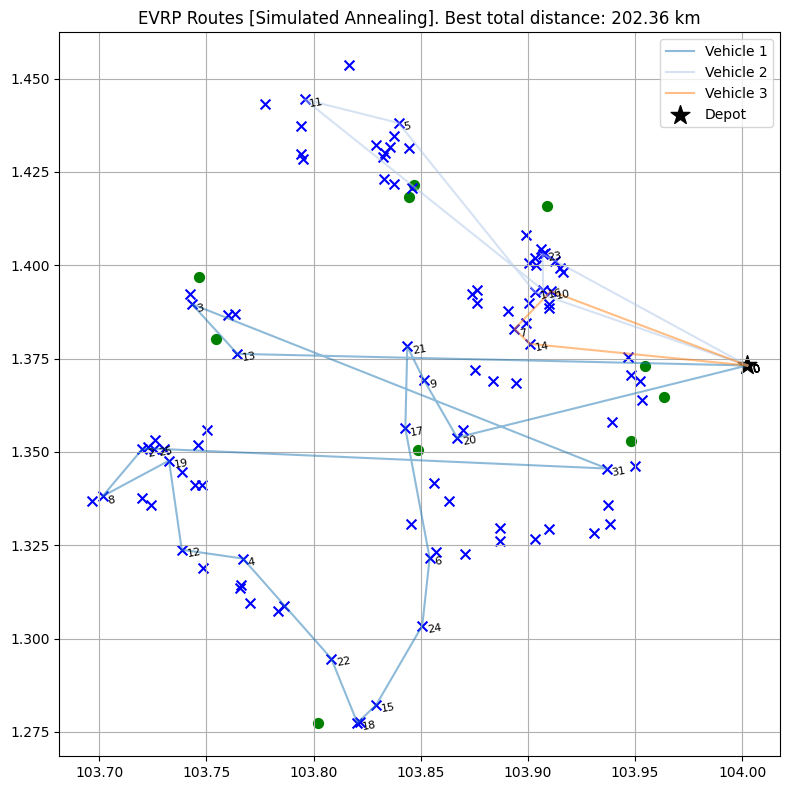

In [ ]:
# Plot Optimal Routes
for v, route in enumerate(best_solution):
    time_taken = 0  
    energy_taken = 0
    battery_level = BATTERY_CAPACITY
    prev_pt = 0
    for point in route:
        time_taken += time_matrix[prev_pt][point]
        energy_taken += energy_matrix[prev_pt][point]
        battery_level -= energy_matrix[prev_pt][point]
        prev_pt = point
        
        print(f"{round(point)} ->", end=" ")
        if point < 1+NUM_CUSTOMERS:
            print(f"{round(point)} 🪫{round(battery_level/BATTERY_CAPACITY * 100)}%", end=", ")
        else:
            battery_level = BATTERY_CAPACITY
            print(f"🔋{round(point)}", end=", ")

    print(f"\n Vehicle {v+1}: Time Taken: {time_taken}. Energy_Taken: {energy_taken:.1f}. ")
    # print(f"Route is feasible {is_route_feasible(route, locations)}")


# conversion_to_allow_indexing
locations_e = np.array([[lon, lat] for (lon, lat) in locations])

plt.figure(figsize=(8, 8))
for i, route in enumerate(best_solution):
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, label=f"Vehicle {i+1}")

    for idx in route:
        # offset slightly
        plt.text(locations_e[idx, 0] + 0.002, locations_e[idx, 1] - 0.002, str(idx), fontsize=8, rotation=10.)
        
plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')
for k in range(1, NUM_CUSTOMERS+1):
    plt.scatter(*locations_e[k], c='blue', s=50, marker='x')

# plt.title(f"EVRP Routes [Simulated Annealing]. Best total distance: {best_cost:.2f} km")
plt.title(f"EVRP Routes [Simulated Annealing]. Best total distance: {total_distance(best_solution, locations):.2f} km")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\andante\AppData\Local\Temp\ipykernel_24844\1280625636.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


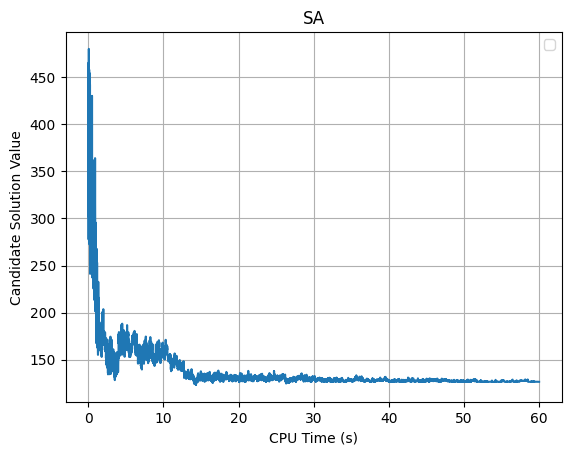

In [11]:
plt.plot(cpu_times, costs)

plt.xlabel('CPU Time (s)')
plt.ylabel('Candidate Solution Value')
plt.title('SA')
plt.legend()
plt.grid(True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f4c4982f-38e1-4a9c-9329-c6527c9f8d0a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>